# Setup

In [58]:
import numpy as np
import scipy.signal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Generate Data

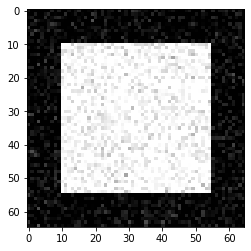

In [66]:
input = np.zeros((65, 65))
input[2, 5] = 0.4
input[12, 17] = 0.7

a,b= np.meshgrid(np.linspace(-1, 1, 65), np.linspace(-1, 1, 65))
Img = np.array(np.logical_and(np.abs(a) < 0.7, np.abs(b) < 0.7),dtype='float32') 

IMG_T=torch.FloatTensor(Img)
IMG_T.shape
IMG_T2 = torch.unsqueeze(IMG_T, dim=0)
IMG_T2.shape
noisyImg = np.clip(Img + np.random.normal(scale=0.1, size=IMG_T2.shape), 0, 1).astype(np.float32) # adding noise from normal distribution
noisyImg_T=torch.FloatTensor(noisyImg)
noisyImg_T.shape
plt.imshow(noisyImg_T[0], cmap='gray')
clean=IMG_T2.unsqueeze(0)
noisy=noisyImg_T.unsqueeze(0)


In [67]:
clean.shape

torch.Size([1, 1, 65, 65])

In [68]:
noisy.shape

torch.Size([1, 1, 65, 65])

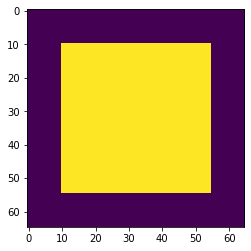

In [69]:
plt.imshow(clean[0][0])

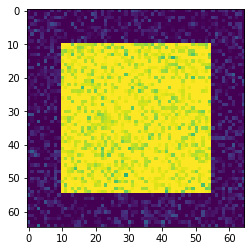

In [70]:
plt.imshow(noisy[0][0])

In [37]:
torch.max(noisy)

tensor(1.)

In [72]:
class Anet(nn.Module):
    def __init__(self, channel=4):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(65,1),padding=(32,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,65),padding=(0,32), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =self.conv1(x)
        out =self.conv2(x1)
        #out = self.conv2(x1)
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 65, 65)
A_net(x).shape

torch.Size([1, 1, 65, 65])

In [77]:
class Anet(nn.Module):
    def __init__(self, channel=4):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(65,1),padding=(32,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,65),padding=(0,32), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =F.relu(self.conv1(x))
        out =F.relu(self.conv2(x1))
        #out = self.conv2(x1)
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 65, 65)
A_net(x).shape

torch.Size([1, 1, 65, 65])

In [78]:
from zmq import device
## reshape the tensors to a matrix

## inner dim =1
[4, 1, 65, 1]
[1,4, 1, 65]



def my_outer(U, V):
  UV=torch.outer(U[0,0,:,0], V[0,0,0,:])
  for i in range(1, U.shape[0]):
    UV=UV+torch.outer(U[i,0,:,0], V[0,i,0,:])
  return UV

## getting singular values

def my_singular(U, V):
  UV=my_outer(U, V)
  return np.array(torch.linalg.svdvals(UV).to('cpu').detach())
   
  

 #def my_svd(U,V):
    #UV=my_outer(U, V)
    #A,S,B= np.array(torch.svd_lowrank(UV, q=8, niter=2, M=None).to('cpu').detach())
    #return A,S,B



def Nuc_norm(U,V):
    sigma_vec= my_singular(U, V)
    return np.sum(sigma_vec)


In [79]:
def plot_epoch(recon_np,noisyImg1, Img):
  #if i % 50 == 0:
    fig = plt.figure(figsize=(7, 7))
    rows = 2
    columns = 2
    plt.subplot(rows, columns, 1)
    #recon_np = recon.squeeze(0).permute(1, 2, 0).to('cpu').detach().numpy()
    plt.imshow(recon_np, cmap='gray')
    plt.axis('off')
    plt.title("recon")
    plt.subplot(rows, columns, 2)
    plt.imshow(Img, cmap='gray')
    plt.axis('off')
    plt.title("Img")
    plt.subplot(rows, columns, 3)
    plt.imshow(noisyImg1, cmap='gray')
    plt.axis('off')
    plt.title("Img+Noise")
    plt.show()
    plt.show()

> ### Training Function








In [82]:
def recon(noisy, clean, alpha=0., iterations=100000, lr=1.e-2, gpu=True):
  import time

  cuda = torch.device('cuda') 

  A_net = Anet()
  x = torch.randn(1, 1, 65, 65)

  if gpu:
    A_net = A_net.to(cuda)
    x = x.to(cuda)
    noisy = noisy.to(cuda)
    clean = clean.to(cuda)

    #U=U.to(cuda)
    #V=V.to(cuda)
  
  optimizer = optim.SGD(A_net.parameters(), lr=lr)

  Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = [],[], [], [], [],[], [], [], [], [],[]

  start = time.time()
  for i in tqdm(range(iterations)):

    recon = A_net(x)
    
    l2_norm = sum(p.pow(2.0).sum() for p in A_net.parameters()) #L2 norm of weights (p**2)
    U, V=[ p for p in A_net.parameters()]  ## get the kernels

    loss_recon = mse(recon, noisy)
    Loss_Rec.append(loss_recon.item())
    
    loss_regu = alpha * l2_norm
    Loss_Reg.append(loss_regu.item())

    loss = loss_recon + loss_regu
    Loss.append(loss.item())

    error = mse(recon, clean)
    Error.append(error.item())
    
    #SVD.append(my_svd(U,V))
    S_values.append(my_singular(U, V))
    UV_outer.append(my_outer(U, V))
    Recons.append(recon)
    U_kernel.append(U)
    V_kernel.append(V)
    
    norm2.append(l2_norm)
    Nuc.append(Nuc_norm(U,V))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    #if i % 10000 == 0:
      #plot_epoch(recon[0].squeeze(0).permute(1, 0).to('cpu').detach().numpy(), noisyImg_T[0], Img)
  end = time.time()
  print(f"ending time in: {((end-start)/60):.3f} mins")
  

  return Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 

# Reco for different Alpha

In [83]:
from numpy.ma.core import outer
Loss_Rec, Loss_Reg, Loss, Error, Sigma, OutP, Rec, kerU, kerV, Norm1, Norm2 = [], [], [], [], [],[], [], [], [], [],[]

#Adapot alpha here!!!!
Alpha = np.linspace(0,0.01,3)

for alpha in Alpha:

  print(alpha)
  # lr 1.e-1 is too large ?
  # ->need more iterations ~ maybe 100000 are too many? 
  loss_rec, loss_reg, loss, error, s, outer, recs, u_ker, v_ker,nuc_norm, norm_2 = recon(noisy, clean, gpu=True , alpha=alpha, iterations=100000)

  Loss_Rec.append(loss_rec)
  Loss_Reg.append(loss_reg)
  Loss.append(loss)
  Error.append(error)
  Sigma.append(s)
  OutP.append(outer)
  Rec.append(recs)
  kerU.append(u_ker)
  kerV.append(v_ker)
  Norm1.append(nuc_norm)
  Norm2.append(norm_2)  


Loss_Rec=np.array(Loss_Rec)
Loss_Reg=np.array(Loss_Reg)
Loss=np.array(Loss)
Error=np.array(Error)
Sigma_arr=np.array(Sigma)
OutP_arr= np.array(OutP)
Rec_arr= np.array(Rec)
kerU_arr= np.array(kerU)
kerV_arr= np.array(kerV)
Norm1_arr= np.array(Norm1)
Norm2_arr= np.array(Norm2)

0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 11.143 mins
0.005


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 11.304 mins
0.01


  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 11.030 mins


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import sys
#sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [12]:
#save files
np.save("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec) 
np.save("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg)
np.save("/home/sbazoobandi/data/Loss.npy",Loss)
np.save("/home/sbazoobandi/data/Error.npy", Error)
np.save("/home/sbazoobandi/data/Alpha.npy", Alpha)
np.save("/home/sbazoobandi/data/Sigma.npy", Sigma_arr)
np.save("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr)
np.save("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr)
np.save("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr)
np.save("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr)
np.save("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr)

# Load files and Plotting

In [ ]:
Loss_Rec=np.load("/home/sbazoobandi/data/Loss_Rec.npy", Loss_Rec) 
Loss_Reg=np.load("/home/sbazoobandi/data/Loss_Reg.npy", Loss_Reg)
Loss=np.load("/home/sbazoobandi/data/Loss.npy",Loss)
Error=np.load("/home/sbazoobandi/data/Error.npy", Error)
Alpha=np.load("/home/sbazoobandi/data/Alpha.npy", Alpha)
Sigma_arr=np.load("/home/sbazoobandi/data/Sigma.npy", Sigma_arr)
OutP_arr=np.load("/home/sbazoobandi/data/OutP_arr.npy", OutP_arr)
Rec_arr=np.load("/home/sbazoobandi/data/Rec_arr.npy", Rec_arr)
kerU_arr=np.load("/home/sbazoobandi/data/kerU_arr.npy", kerU_arr)
kerV_arr=np.load("/home/sbazoobandi/data/kerV_arr.npy", kerV_arr)
Norm1_arr=np.load("/home/sbazoobandi/data/Norm1_arr.npy", Norm1_arr)

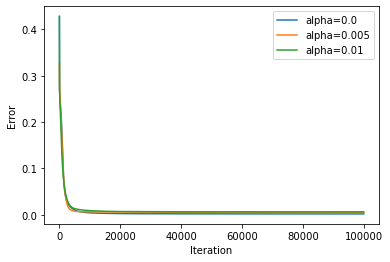

In [84]:
for i in range(Alpha.shape[0]):
  plt.plot(Error[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()


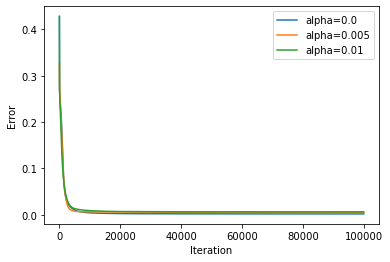

In [85]:
for i in range(Alpha.shape[0]):
  plt.plot(Error[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.legend()
plt.show()
class Anet(nn.Module):
    def __init__(self, channel=4):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(65,1),padding=(32,0), padding_mode='circular', bias=False, groups=1) #circular
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,65),padding=(0,32), padding_mode='circular',bias=False, groups=1)
        #groups
    def forward(self, x):
        x1 =self.conv1(x)
        out =self.conv2(x1)
        #out = self.conv2(x1)
        #U = self.conv1.weight.detach().clone()
        #V = self.conv2.weight.detach().clone()
        return out
A_net = Anet() #.to(device)
mse = nn.MSELoss()
x = torch.randn(1, 1, 65, 65)
A_net(x).shape

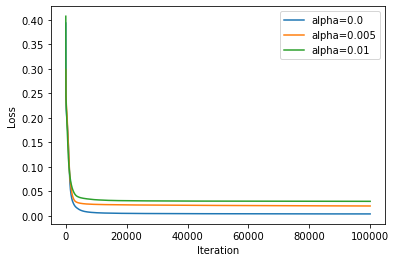

In [86]:
for i in range(Alpha.shape[0]):
  plt.plot(Loss[i,::1], label="alpha={}".format(Alpha[i]))

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()
plt.show()


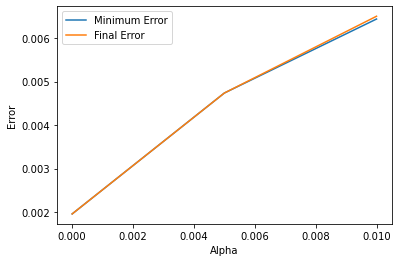

In [87]:
plt.plot(Alpha, np.min(Error, axis=1), label="Minimum Error")
plt.plot(Alpha, Error[:,-1], label="Final Error")

plt.xlabel("Alpha")
plt.ylabel("Error")

plt.legend()
plt.show()


  0%|          | 0/50000 [00:00<?, ?it/s]

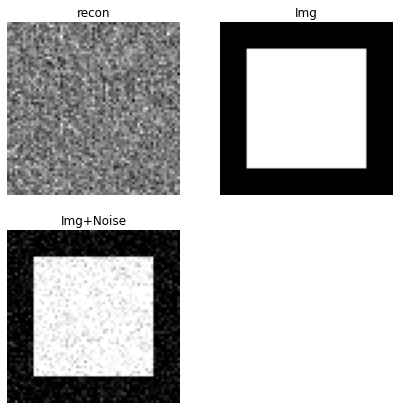

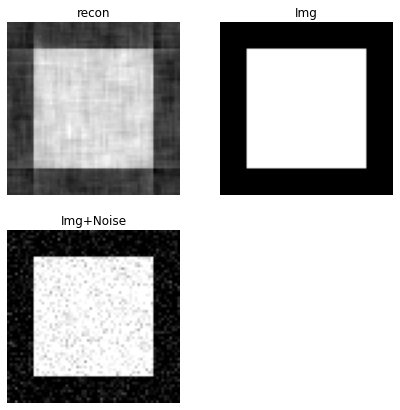

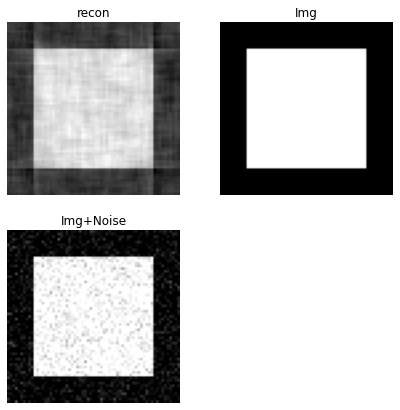

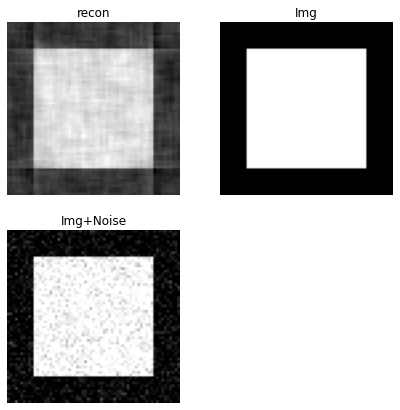

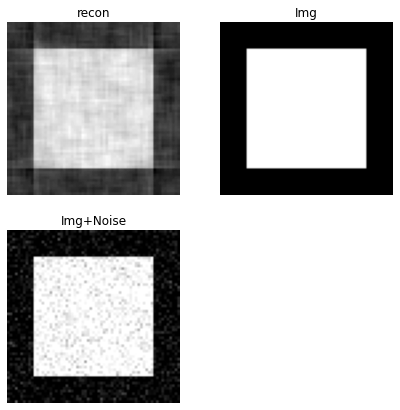

ending optimization in: 5.183 mins


In [76]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.002, iterations=50000) ## without ReLU

  0%|          | 0/50000 [00:00<?, ?it/s]

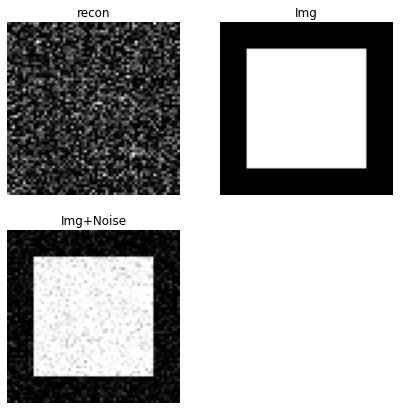

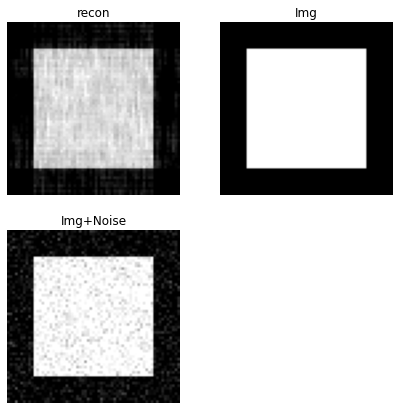

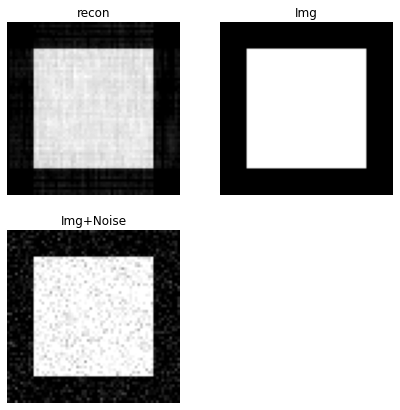

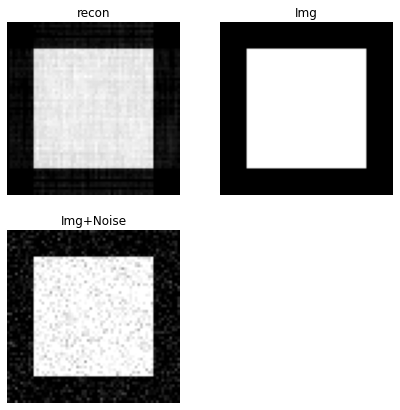

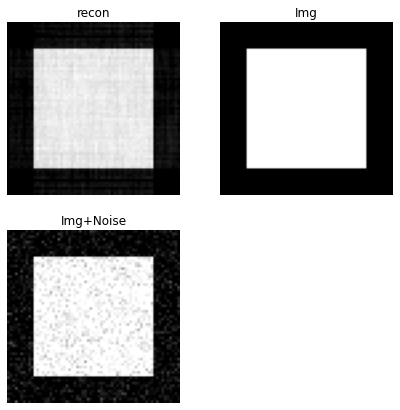

ending optimization in: 5.640 mins


In [81]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.002, iterations=50000) ## ReLU CNN

In [120]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.005, iterations=100000) #ReLU

  0%|          | 0/100000 [00:00<?, ?it/s]

ending time in: 11.110 mins


In [124]:
Loss_Rec, Loss_Reg, Loss, Error, S_values, UV_outer, Recons, U_kernel, V_kernel, Nuc, norm2 = recon(noisy, clean, gpu=True , alpha=0.001, iterations=70000)##ReLU 

  0%|          | 0/70000 [00:00<?, ?it/s]

ending time in: 7.727 mins


Text(0.5, 1.0, 'Plot of singular values')

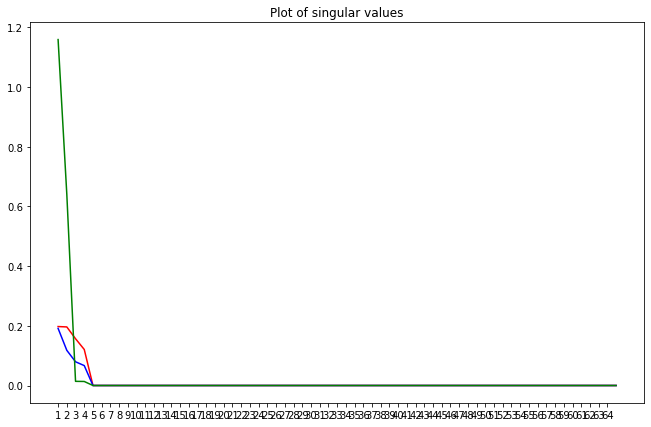

In [89]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "red" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "blue" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[49999], "green" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'Plot of singular values')

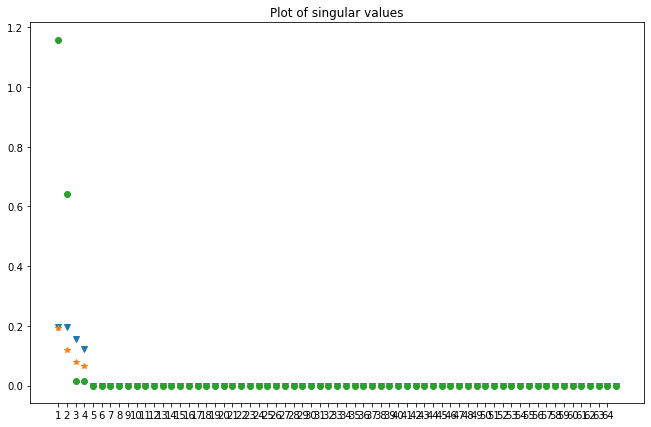

In [90]:
  plt.figure(figsize= (11,7))

  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[10], "v" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[500], "*" )
  #plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[25000], "x" )
  plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[49999], "o" )
  plt.xticks(np.arange(1, len(S_values[0] + 1)))
  #plt.yscale("log")
  plt.title("Plot of singular values")

Text(0.5, 1.0, 'singular values')

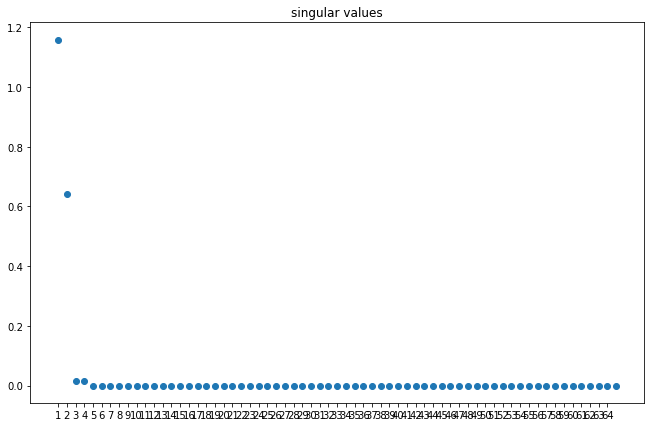

In [91]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[49999], "o" )
plt.xticks(np.arange(1, len(S_values[0] + 1)))
#plt.yscale("log")
plt.title("singular values")

Text(0.5, 1.0, 'singular values')

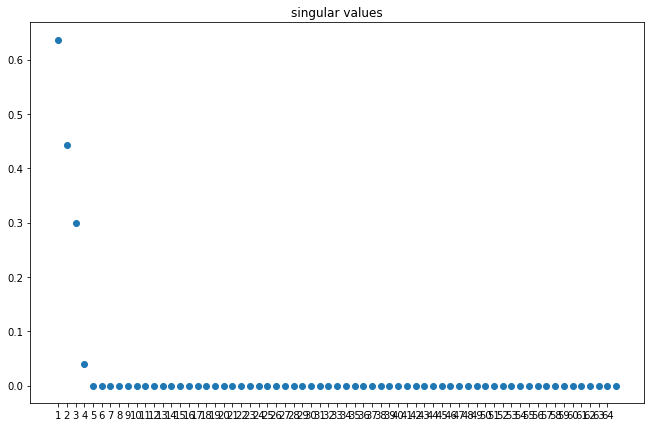

In [121]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[99999], "o" ) ####100,000 itr.!!!!
plt.xticks(np.arange(1, len(S_values[0] + 1)))
#plt.yscale("log")
plt.title("singular values")

Text(0.5, 1.0, 'singular values')

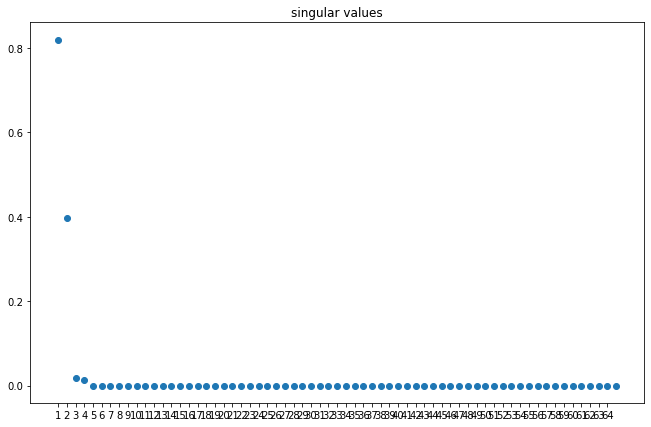

In [125]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[69999], "o" ) ####70,000 itr.!!!!
plt.xticks(np.arange(1, len(S_values[0] + 1)))
#plt.yscale("log")
plt.title("singular values")

In [92]:
kernel=UV_outer[49000].cpu().detach()

In [93]:
kernel.shape

torch.Size([65, 65])

In [94]:
kernel

tensor([[-0.0288, -0.0276, -0.0241,  ..., -0.0189, -0.0269, -0.0323],
        [-0.0309, -0.0298, -0.0262,  ..., -0.0215, -0.0291, -0.0345],
        [-0.0383, -0.0366, -0.0331,  ..., -0.0274, -0.0362, -0.0412],
        ...,
        [-0.0140, -0.0136, -0.0097,  ..., -0.0042, -0.0122, -0.0187],
        [-0.0170, -0.0165, -0.0126,  ..., -0.0073, -0.0153, -0.0215],
        [-0.0192, -0.0190, -0.0148,  ..., -0.0107, -0.0178, -0.0236]])

In [95]:
_,Sigma,_=torch.svd_lowrank(kernel, q=4, niter=2, M=None)

Text(0.5, 1.0, 'singular values')

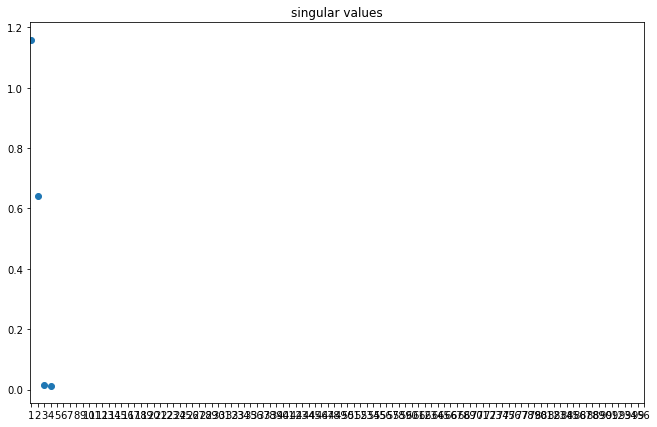

In [96]:
plt.figure(figsize= (11,7))
#for i in range(len(S_values)):
#plt.plot(np.arange(1, len(S_values[0]) + 1), S_values[i], "o" )
plt.plot(np.arange(1, len(Sigma) + 1),Sigma, "o" )
plt.xticks(np.arange(1, 97))
#plt.yscale("log")
plt.title("singular values")

In [98]:
rec_f=Recons[49000].cpu().detach()

In [99]:
rec_f.shape

torch.Size([1, 1, 65, 65])

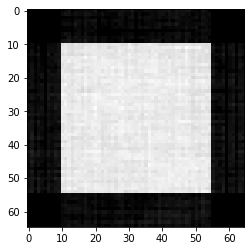

In [100]:
plt.imshow(rec_f[0][0], cmap="gray")

In [122]:
rec_f=Recons[99000].cpu().detach()

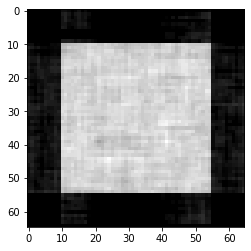

In [123]:
plt.imshow(rec_f[0][0], cmap="gray") ## double iteration and alpha >> double itr=100000, alpha=0.005

In [126]:
rec_f=Recons[69000].cpu().detach()

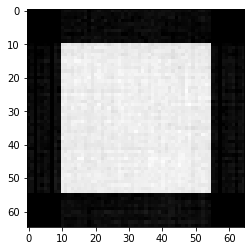

In [127]:
plt.imshow(rec_f[0][0], cmap="gray") ## double iteration and alpha >> double itr=70000, alpha=0.001

In [101]:
U, s, V = np.linalg.svd(rec_f[0][0], full_matrices=False)

Text(0.5, 1.0, 'singular values')

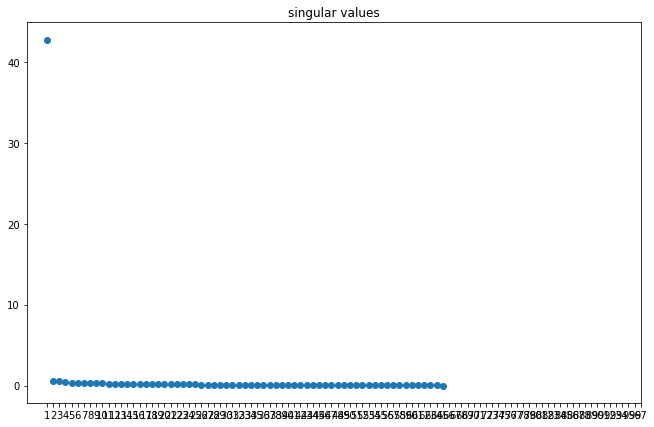

In [102]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("singular values")

In [103]:
UV_outer

[tensor([[-5.8695e-03, -5.7807e-03,  2.2854e-03,  ..., -1.4245e-03,
          -4.8219e-03, -2.3845e-03],
         [ 6.9111e-03, -9.2085e-05, -4.2752e-03,  ...,  1.2400e-03,
           7.2622e-03, -7.6923e-04],
         [-2.9352e-03, -8.2165e-03,  1.5781e-03,  ..., -9.0196e-03,
          -2.1203e-03, -6.6564e-03],
         ...,
         [ 2.1196e-03,  3.2128e-03, -1.9000e-03,  ...,  1.3796e-03,
           2.4579e-03, -8.3792e-04],
         [ 6.8710e-03, -1.7509e-03, -3.0906e-03,  ..., -4.2713e-03,
           6.6542e-03, -2.5438e-03],
         [ 9.2506e-04,  4.7353e-05,  5.4086e-04,  ...,  1.8274e-03,
           6.1338e-05,  3.6456e-03]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[-6.0234e-03, -5.9375e-03,  2.1321e-03,  ..., -1.5818e-03,
          -4.9810e-03, -2.5395e-03],
         [ 6.9791e-03, -2.0979e-05, -4.2233e-03,  ...,  1.3175e-03,
           7.3294e-03, -7.1346e-04],
         [-3.0374e-03, -8.3087e-03,  1.4955e-03,  ..., -9.1123e-03,
          -2.2224e-03, -6.7484e-03]

In [104]:
UV_kernel=UV_outer[49000].cpu().detach()

In [105]:
UV_kernel.shape

torch.Size([65, 65])

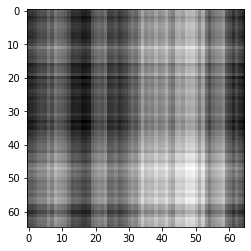

In [106]:
plt.imshow(UV_kernel, cmap="gray")

In [107]:
U, s, V = np.linalg.svd(UV_kernel, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

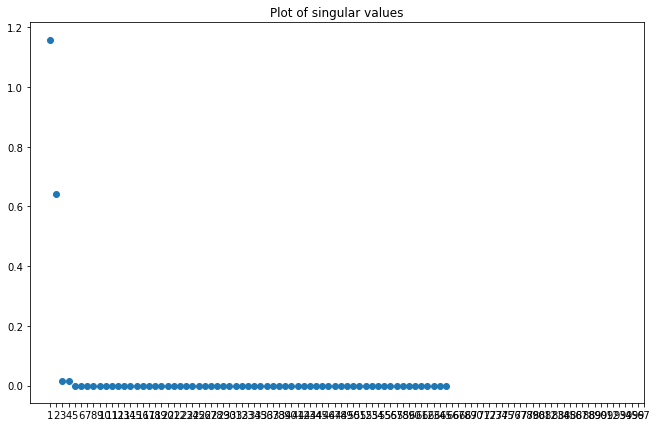

In [108]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [109]:
UV_kernel=np.array(UV_kernel)

In [110]:
UV_kernel.shape

(65, 65)

In [111]:
UV_kernel_transformed= np.fft.fft2(UV_kernel, axes=[0,1])

In [112]:
U, s, V = np.linalg.svd(UV_kernel_transformed, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

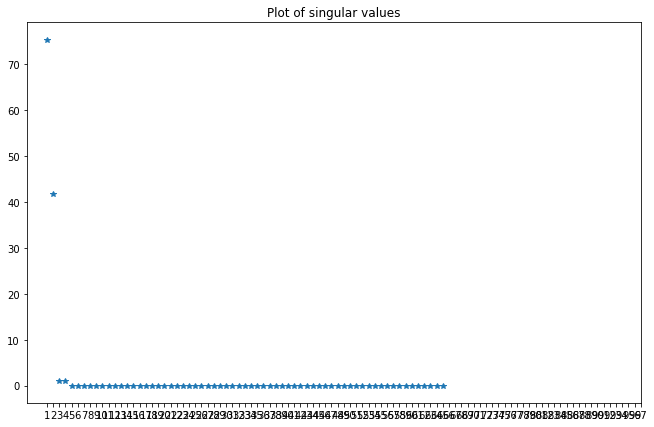

In [113]:
plt.figure(figsize= (11,7))
plt.plot(np.arange(1, len(s) + 1),s, "*" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [114]:
U, s, V = np.linalg.svd(noisyImg, full_matrices=False)

Text(0.5, 1.0, 'Plot of singular values')

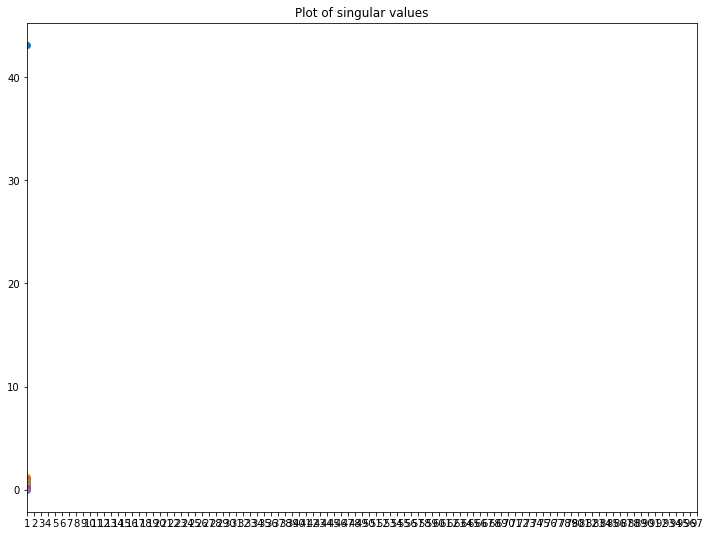

In [115]:
plt.figure(figsize= (12,9))
plt.plot(np.arange(1, len(s) + 1),s, "o" )
plt.xticks(np.arange(1, 98))
#plt.yscale("log")
plt.title("Plot of singular values")

In [116]:
Nuc

[0.6681757,
 0.66934884,
 0.6705743,
 0.6716968,
 0.67256445,
 0.67308074,
 0.67321736,
 0.67300063,
 0.6724841,
 0.67172295,
 0.67076975,
 0.66966504,
 0.6684447,
 0.66713864,
 0.66577035,
 0.6643608,
 0.6629202,
 0.6614618,
 0.6599937,
 0.6585168,
 0.6570374,
 0.6555559,
 0.6540757,
 0.6525969,
 0.6511226,
 0.6496523,
 0.64818484,
 0.6467214,
 0.64526266,
 0.6438079,
 0.64235777,
 0.640915,
 0.6394773,
 0.6380467,
 0.636623,
 0.6352068,
 0.6337988,
 0.6323994,
 0.6310059,
 0.6296214,
 0.6282441,
 0.6268748,
 0.6255129,
 0.62415886,
 0.62281364,
 0.62147546,
 0.6201452,
 0.61882097,
 0.6175036,
 0.6161929,
 0.6148878,
 0.6135902,
 0.6122977,
 0.6110124,
 0.60973334,
 0.6084631,
 0.6071983,
 0.6059403,
 0.6046912,
 0.60344726,
 0.60221094,
 0.6009819,
 0.5997594,
 0.5985444,
 0.59733665,
 0.5961347,
 0.5949411,
 0.59375364,
 0.59257287,
 0.5913984,
 0.5902314,
 0.58907115,
 0.5879176,
 0.58677006,
 0.58563,
 0.5844955,
 0.5833678,
 0.5822472,
 0.58113146,
 0.5800209,
 0.5789158,
 0.577

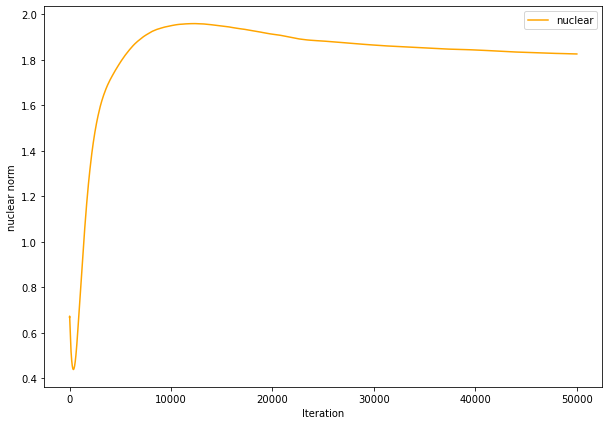

In [117]:
## nuclear norm
plt.figure(figsize=(10, 7))
plt.plot(Nuc, color='orange', label='nuclear')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('nuclear norm')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()

In [118]:
norm2

[tensor(1.6588, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6612, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6638, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6662, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6682, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6695, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6702, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6701, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6695, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6685, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6671, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6654, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6635, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6614, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6592, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6569, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6546, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6522

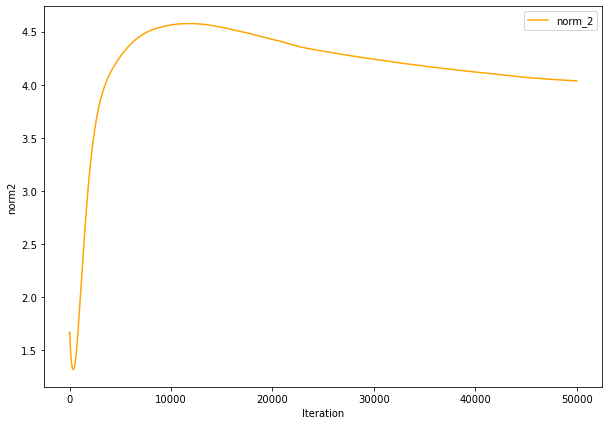

In [119]:
## 2 norm
plt.figure(figsize=(10, 7))
plt.plot(norm2, color='orange', label='norm_2')
#plt.title('alpha=0.1')
plt.xlabel('Iteration')
plt.ylabel('norm2')
plt.legend()
#plt.savefig('/content/drive/My Drive/nuc.png')
plt.show()